In [1]:
import pandas as pd
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import gensim.downloader as api
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import KeyedVectors


# nltk.download('stopwords')
# nltk.download("punkt")
# nltk.download('punkt_tab')
# nltk.download('wordnet')

print(nltk.data.path)


['C:\\Users\\ghj/nltk_data', 'c:\\Users\\ghj\\anaconda3\\nltk_data', 'c:\\Users\\ghj\\anaconda3\\share\\nltk_data', 'c:\\Users\\ghj\\anaconda3\\lib\\nltk_data', 'C:\\Users\\ghj\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


In [2]:
# train_data_path = "https://drive.google.com/uc?export=download&id=16CHSMU1ffqMZc__bTZngjZOjREghWKid"
# test_data_path = "https://drive.google.com/uc?export=download&id=1tUMuS0ol19IUO8zgOcHpHWLV2pQVA8qZ"

# Get data locally during developing to avoid fetching time. (!) Comment when deploying and uncomment upper two
train_data_path = "../work_data/train.csv"
test_data_path = "../work_data/test.csv"

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data.head()

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative


# EDA

In [3]:
train_data.isnull().sum()

review       0
sentiment    0
dtype: int64

<Axes: xlabel='count', ylabel='sentiment'>

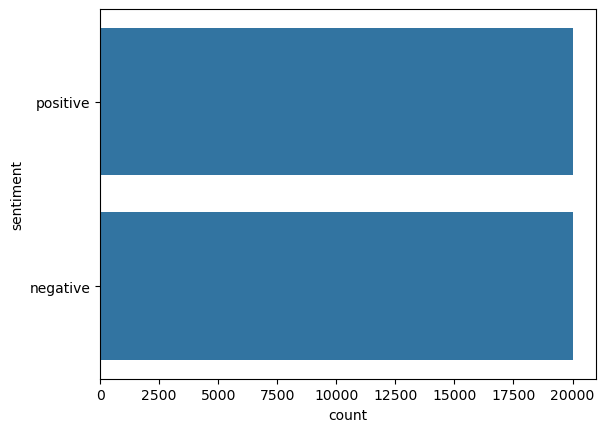

In [4]:
sns.countplot(train_data["sentiment"])

We have a balanced dataset, which is nice

# Feature engineering

In [5]:
X = train_data["review"]
y = train_data["sentiment"]

## Data cleaning

In [6]:
def clean_text(text):
    text = re.sub(r'\W', ' ', str(text))  # Remove special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)  # Remove single characters from start
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Replace multiple spaces with single space
    text = re.sub(r'^b\s+', '', text)  # Remove prefixed 'b'
    text = text.lower()
    return text

X = X.apply(clean_text)

X.head(2)


0    i caught this little gem totally by accident b...
1    i can believe that let myself into this movie ...
Name: review, dtype: object

## Tokenization

In [7]:
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

X = X.apply(tokenize)

X.to_frame().head()

,review
0,"[i, caught, this, little, gem, totally, by, ac..."
1,"[i, can, believe, that, let, myself, into, thi..."
2,"[spoiler, alert, it, just, gets, to, me, the, ..."
3,"[if, there, one, thing, ve, learnt, from, watc..."
4,"[i, remember, when, this, was, in, theaters, r..."


# Stop-words filtering

In [8]:
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return [word for word in text if word not in STOPWORDS]

X = X.apply(remove_stopwords)

X.head()

0    [caught, little, gem, totally, accident, back,...
1    [believe, let, movie, accomplish, favor, frien...
2    [spoiler, alert, gets, nerve, people, remake, ...
3    [one, thing, learnt, watching, george, romero,...
4    [remember, theaters, reviews, said, horrible, ...
Name: review, dtype: object

# Stemming vs Lemmatization

## Stemming

In [9]:
# Uncomment later, takes two much time when running all
stemmer = PorterStemmer()

def stem_words(text):
    return [stemmer.stem(word) for word in text]

X_stemmed = X.apply(stem_words)

X_stemmed.head()

## Lemmatization



In [10]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return [lemmatizer.lemmatize(word) for word in text]

X_lemmatized = X.apply(lemmatize_words)

X.head()

0    [caught, little, gem, totally, accident, back,...
1    [believe, let, movie, accomplish, favor, frien...
2    [spoiler, alert, gets, nerve, people, remake, ...
3    [one, thing, learnt, watching, george, romero,...
4    [remember, theaters, reviews, said, horrible, ...
Name: review, dtype: object

As seen here, lemmatization provides much more accurate and in my case was ~3 times faster. So for now, I dont see any reason to prefer stemming over lemmatization.

# Vectorization

## Bag-of-Words

In [11]:
vectorizer = CountVectorizer()

X = X.apply(lambda words: ' '.join(words))  # Convert lists to strings
X_bow = vectorizer.fit_transform(X)


## Word Embedding

In [12]:
# word2vec = api.load("word2vec-google-news-300")
word2vec = KeyedVectors.load("word2vec-google-news-300.kv", mmap='r')

# Get the word vector for "king"
vector = word2vec["king"]

# Check similarity
similarity = word2vec.similarity("king", "queen")

In [13]:
similarity

0.6510957

In [14]:
# word2vec.save("word2vec-google-news-300.kv")

OSError: [Errno 22] Invalid argument: 'word2vec-google-news-300.kv.vectors.npy'